In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import numpy as np
import cv2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import pandas as pd
# for data augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PARENT_DIR = "drive/MyDrive/ChestXRays"

train_dir = PARENT_DIR + "/train"
val_dir = PARENT_DIR + "/validate"
test_dir = PARENT_DIR + "/test"

save_model_name = 'new_model_1.h5'

# CATEGORIES = ["NORMAL", "PNEUMONIA"]
IMG_SIZE_X = 400
IMG_SIZE_Y = 400

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) # 0 - 255 to 0 - 1
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE_X,IMG_SIZE_Y), # image size
        batch_size=64,
        color_mode="grayscale", 
        class_mode='binary' # type of label array return
)

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE_X,IMG_SIZE_Y),
        batch_size=64,
        color_mode="grayscale",
        class_mode='binary')

testing_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE_X,IMG_SIZE_Y),
        batch_size=64,
        # shuffle = False,
        color_mode="grayscale",
        class_mode='binary')

Found 4335 images belonging to 2 classes.
Found 1244 images belonging to 2 classes.
Found 277 images belonging to 2 classes.


FileNotFoundError: ignored

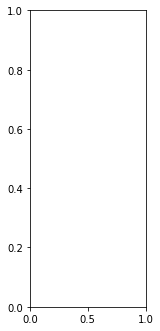

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
x = train_generator.next()
print(len(x))

2


In [ ]:
x[1]


array([0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [ ]:
# can be due to less no of neurons
# regularization (L1, L2)
# other arch 
  # resnet
  # mass rcnn
  # rcnn

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), activation = "relu", input_shape=(IMG_SIZE_X,IMG_SIZE_Y,1)) ,
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)), # reduce spatial resolution
# kernel size 3x3
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), activation = "relu") ,
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 

        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), activation = "relu") ,
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 

        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), activation = "relu") ,
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 

        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), activation = "relu") ,
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 

        tf.keras.layers.Flatten(), # size will be selected aumatically
        tf.keras.layers.Dense(64, activation = "relu"),

        # softmax gives prob dist sum = 1 and typically used for multivariate classification
        tf.keras.layers.Dense(1, activation = "sigmoid"), # classifying two categories only
])

model.compile(
    optimizer="adam",
#               optimizer='SGD',
#               optimizer='rmsprop',
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

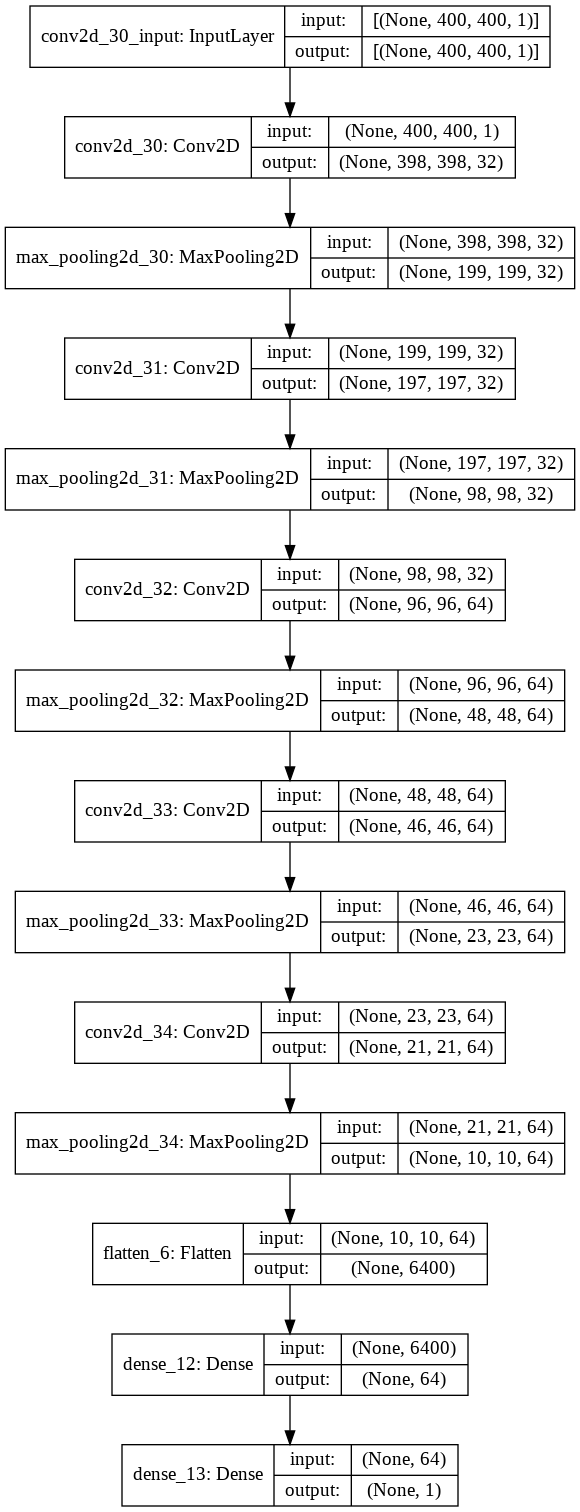

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

Load weights if already trained


In [ ]:
# x = train_generator.next()
model.load_weights(PARENT_DIR +"/" + save_model_name)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        3

Early stopping


In [ ]:
# stop if accuracy does not improve for 3 consecutive ittr (based on val_loss)
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
# Reduce learning rate when a metric has stopped improving
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
# Assigning Class Weights
# penalize minority class more.

weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), weights))
print(cw)

{0: 2.55, 1: 0.6219512195121951}


# Training

---



In [ ]:
# model.fit(X,y, epochs = 1)

model.fit(
        train_generator,
        # steps_per_epoch=5232  // 64, # 28709 training images
        epochs=5,
        validation_data=validation_generator,
        # validation_steps=624 // 64,
        class_weight = cw,
        callbacks = callbacks_list
        )

model.save_weights('drive/MyDrive/ChestXRays/'+ save_model_name)
 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
68/68 [==============================] - 1862s 27s/step - loss: 0.4760 - accuracy: 0.8235 - val_loss: 0.2930 - val_accuracy: 0.8802
Epoch 2/5
68/68 [==============================] - 859s 13s/step - loss: 0.1979 - accuracy: 0.9218 - val_loss: 0.3330 - val_accuracy: 0.8674
Epoch 3/5
68/68 [==============================] - 863s 13s/step - loss: 0.1374 - accuracy: 0.9458 - val_loss: 0.2202 - val_accuracy: 0.9156
Epoch 4/5
68/68 [==============================] - 884s 13s/step - loss: 0.1072 - accuracy: 0.9569 - val_loss: 0.1626 - val_accuracy: 0.9405
Epoch 5/5
68/68 [==============================] - 889s 13s/step - loss: 0.0861 - accuracy: 0.9631 - val_loss: 0.2632 - val_accuracy: 0.9148


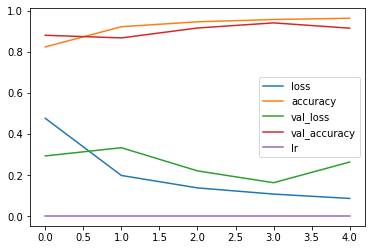

In [ ]:
#  visualize the progress of all metrics throughout the total epochs lifetime
pd.DataFrame(model.history.history).plot()

In [ ]:
test_accu = model.evaluate(testing_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

5/5 [==============================] - 14s 2s/step - loss: 1.4182 - accuracy: 0.6751
The testing accuracy is : 67.50902533531189 %


Training - 02

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2
68/68 [==============================] - 1289s 19s/step - loss: 0.1169 - accuracy: 0.9520 - val_loss: 0.4099 - val_accuracy: 0.8899
Epoch 2/2
5/5 [==============================] - 58s 14s/step - loss: 1.3974 - accuracy: 0.6751


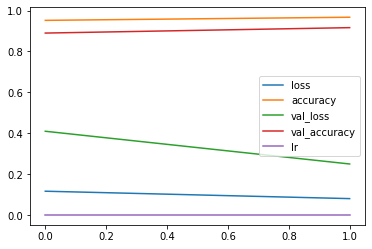

In [ ]:
# model.fit(X,y, epochs = 1)

model.fit(
        train_generator,
        # steps_per_epoch=5232  // 64, # 28709 training images
        epochs=2,
        validation_data=validation_generator,
        # validation_steps=624 // 64,
        class_weight = cw,
        callbacks = callbacks_list
        )

model.save_weights('drive/MyDrive/ChestXRays/'+ save_model_name)
 
#  visualize the progress of all metrics throughout the total epochs lifetime
pd.DataFrame(model.history.history).plot()

test_accu = model.evaluate(testing_generator)
# print('The testing accuracy is :',test_accu[1]*100, '%')

In [ ]:
val_accu = model.evaluate(validation_generator)
test_accu = model.evaluate(testing_generator)

5/5 [==============================] - 16s 3s/step - loss: 1.3974 - accuracy: 0.6751
